# Fitting multi-position curves from multiple files

This script uses functions and a class object defined in the fit_FCS.py file. **Make sure that the 2 files are saved in the same location !!**

The idea behind class usage is to embed in the class a number of experimental informations (concentrations, laser power, acquisition parameters...), that can be recalled afterwards.

## Table of content
- [Import Libraries and functions](#libraries)
- [Define the input and output folders](#folders)
- [Define the experimental parameters](#exp_param)
- [Define the fitting parameters](#fit_param)
- [Manually select good data](#select)



---

---

## Import Libraries and functions <a class="anchor" id="libraries"></a>



In [10]:
import numpy as np
import pandas as pd
from numpy import loadtxt
import os
import linecache
from lmfit import Parameters, minimize


import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from fit_FCS import *
from fit_FCS import func1,func2

In [11]:
help(FCS_Csv)

Help on class FCS_Csv in module fit_FCS:

class FCS_Csv(builtins.object)
 |  FCS_Csv(Filename)
 |  
 |  This script defines a class object named FCS_csv().
 |  Its rationale is to store and analyze data related to FCS curves.
 |  It was developed to extract and analyze multiposition datasets acquired with ISS.
 |  The functions load_curves, extract_date and extract_CPS will instanciate some parameters of the objects.
 |  It also contains methods to fit the auto-correlation curves with one or two species.
 |  
 |  Methods defined here:
 |  
 |  __init__(self, Filename)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  __str__(self)
 |      Return str(self).
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)



---
## Define the input and output folders <a class='anchor' id='folders'></a>


- Change the paths to the input folder : **this folder should only contain the csv files to analyze**. No calibration file, no image files, no other folder!!
- Change the path of the output folder : this is the folder where all results will be stored (graphs, dataframes...)
- You can manually remove unwanted files from the analysis (in this case, uncomment the two lines and change names accordingly)



In [4]:
InputFolder = '/Users/christine/Documents/Data/DropInOut/FCS/Vincent/231123/csv/' 
OutputFolder = '/Users/christine/Documents/Data/DropInOut/FCS/Vincent/231123/Results/'

files = os.listdir(InputFolder)
#files.remove('.DS_Store')

# Remove files that do not have the expected number of curves or for other reasons
#files.remove('10µW-pept_FITC600µM+arn0.5g.l_9position-time0.csv')
#files.remove('40µW-pept_FITC600µM+arn0.5g.l_9position-time0.csv')

print(files)


['10µW-pept_FITC600µM+arn0.5g.l_9position-time10.csv', '10µW-pept_FITC600µM+arn0.5g.l_9position-time15.csv', '10µW-pept_FITC600µM+arn0.5g.l_9position-time60.csv', '10µW-pept_FITC600µM+arn0.5g.l_9position-time50.csv', '10µW-pept_FITC600µM+arn0.5g.l_9position-time45.csv', '10µW-pept_FITC600µM+arn0.5g.l_9position-time0.csv', '10µW-pept_FITC600µM+arn0.5g.l_9position-time5.csv', '10µW-pept_FITC600µM+arn0.5g.l_9position-time55.csv', '10µW-pept_FITC600µM+arn0.5g.l_9position-time40.csv', '10µW-pept_FITC600µM+arn0.5g.l_9position-time30.csv', '10µW-pept_FITC600µM+arn0.5g.l_9position-time25.csv', '10µW-pept_FITC600µM+arn0.5g.l_9position-time35.csv', '10µW-pept_FITC600µM+arn0.5g.l_9position-time20.csv']


---

## Define the experimental parameters <a class='anchor' id='exp_param'></a>

- Enter the w0 and z0 obtained from the calibration
- Enter the experimental conditions


In [5]:
w0 = 0.37
Z0 = 6

exp_guy = "Vincent"
fluo = 12      # concentration of the fluorescent peptide in nM
cold = 600     # concentration of the unlabeled peptide in uM
rna = 0.5      # concentration of the RNA in mg/mL
PKA = 0        # concentration of the PKA in U
LPP = 0        # concentration of the lambda phosphatase in U
mncl2 = 0      # concentration of MnCl2 in mM
height = 1     # distance of measurement (from the coverslip)

# Enter number of species for the fit - if 2, 1 species fitting will als be performed, fit performanace will be compared.
nb = 2

# Do you want to plot the individual FCS + FIT curves (0=no / 1=yes) ?
plotcorr = 1

# Do you want to print the individual results of the fits (0=no / 1=yes) ?
printres = 0

---

## Define the fitting parameters <a class='anchor' id='fit_param'></a>

Here are defined the initial and bounding values for the different parameters to be fitted. If you want ot fix one of these parameters, choose Nfix=1.



In [6]:
# Number of molecules min/max
Ninit = 10
Nmin = 0.00001
Nmax = 10000
Nfix = 0  # (0=no / 1=yes)

# Diffusion time min/max in s for 1 component fit
tinit = 0.010
tmin = 0.00001
tmax = 10
tfix = 0  # (0=no / 1=yes)

# Diffusion time 1 min/max in s
t1init = 0.010
t1min = 0.00001
t1max = 10
t1fix = 0  # (0=no / 1=yes)

# Diffusion time 2 min/max in s (for 2 species fitting)
t2init = 0.03
t2min = 0.00001
t2max = 10
t2fix = 0  # (0=no / 1=yes)

# Fraction of species 1 (for 2 species fitting)
F1init = 0.5
F1min = 0.1
F1max = 1
F1fix = 0  # (0=no / 1=yes)

# Offset
Offinit = 0
Offmin = -1
Offmax = 1
Offfix = 0  # (0=no / 1=yes)

# Z/W ratio
Rinit = 10
Rmin = 0.1
Rmax = 20
Rfix = 0  # (0=no / 1=yes)

---

## Manually select good data <a class='anchor' id='select'></a>






There is nothing to mofidy in this cell, just run it ! Each curve will be plotted 


10µW-pept_FITC600µM+arn0.5g.l_9position-time0.csv
1
2


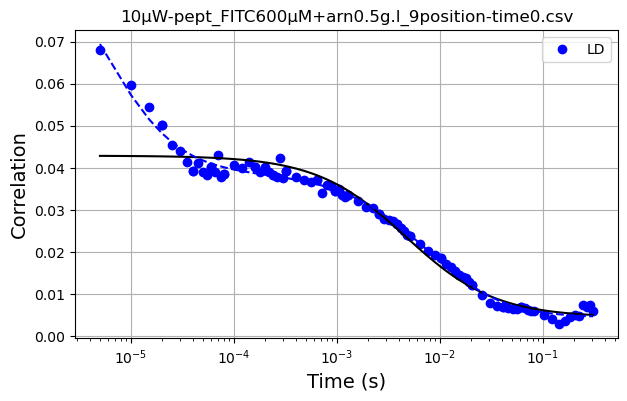

Do you want to keep the data for further analysis? (yes/no):  yes


Data will be kept for further analysis.
1
2


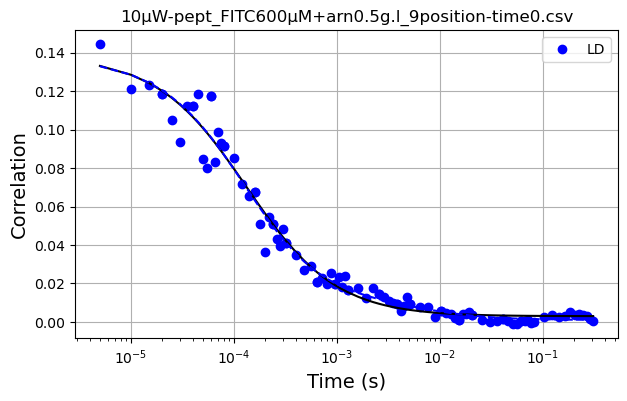

Do you want to keep the data for further analysis? (yes/no):  yes


Data will be kept for further analysis.
1
2


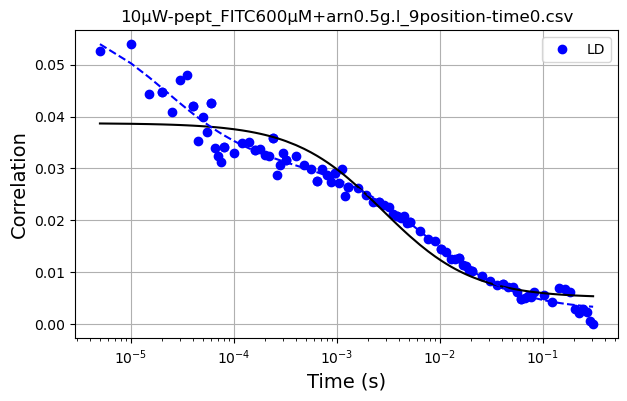

Do you want to keep the data for further analysis? (yes/no):  yes


Data will be kept for further analysis.
1
2


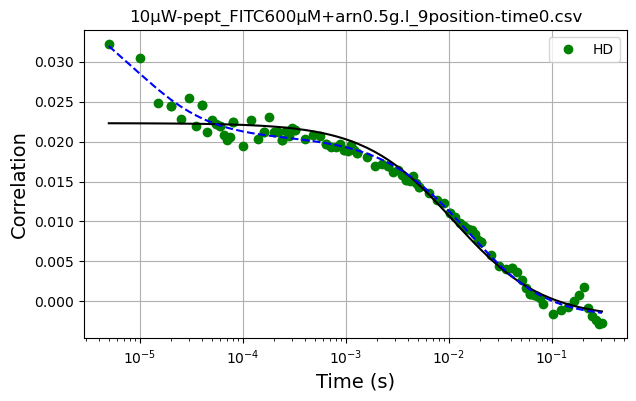

Do you want to keep the data for further analysis? (yes/no):  yes


Data will be kept for further analysis.
1
2


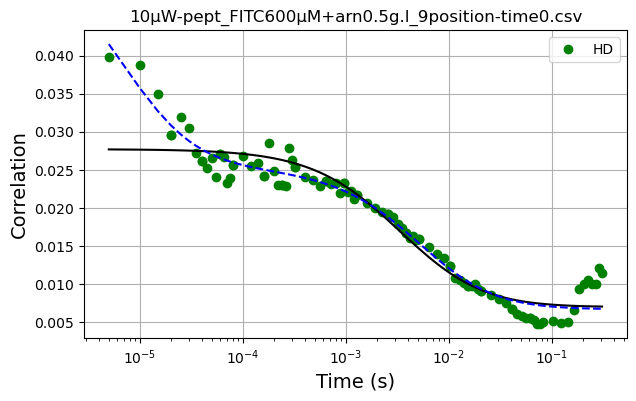

Do you want to keep the data for further analysis? (yes/no):  yes


Data will be kept for further analysis.
1
2


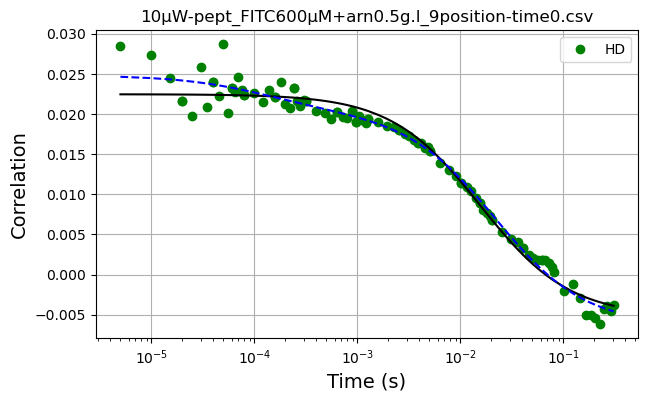

Do you want to keep the data for further analysis? (yes/no):  yes


Data will be kept for further analysis.
1
2


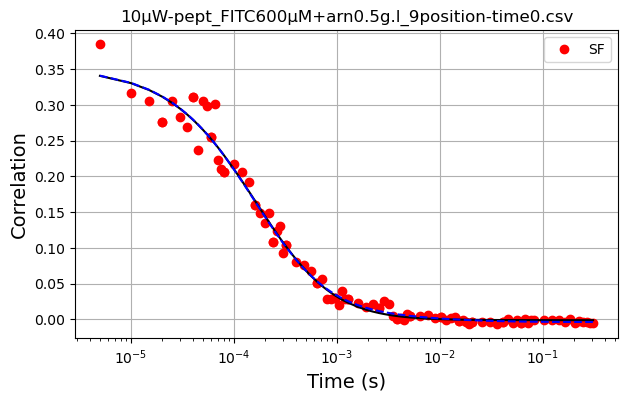

Do you want to keep the data for further analysis? (yes/no):  yes


Data will be kept for further analysis.
1
2


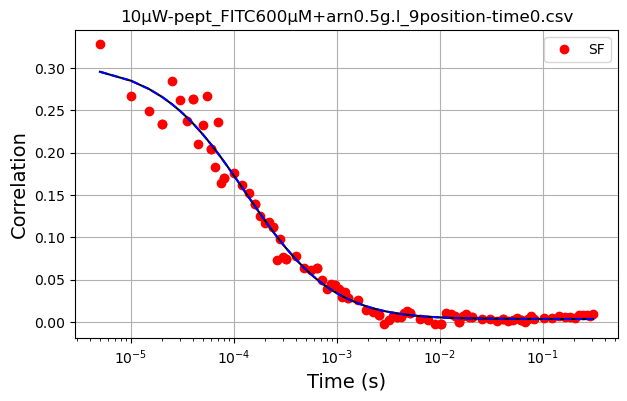

KeyboardInterrupt: Interrupted by user

In [8]:
files.sort()

names=[]
nombres=[]
power=[]
cps=[]
phase=[]
times=[]
pop=[]
tauds=[]
tauds1=[]
tauds2=[]

difcoefs1=[]
difcoefs2=[]
fraction=[]
chi2=[]
offset=[]
status=[]
#position=[]


for filename in files:
    print(filename)
    
       
    data=loadtxt(InputFolder+filename, delimiter=',', skiprows=13)
    title = filename
    xdata = data[0,:]
    
    
    colors=[]
    pos=[]

    for k in range(1,4):
        pos.append('LD')
        colors.append('b')

    for k in range(4,7):
        pos.append('HD')
        colors.append('g')

    for k in range(7,10):
        pos.append('SF')
        colors.append('r')

    for k in range(1,10):
        ydata = data[(2*k+1),:]        
        

        fig = plt.figure(figsize=(7,4))
        gs = gridspec.GridSpec(2, 1)
        ax1 = fig.add_subplot(gs[0])

        ax1.set_title(title)
        ax1.set_xlabel('Time (s)', fontsize=14)
        ax1.set_ylabel('Correlation', fontsize=14)
        ax1.set_xscale('log')
        ax1.grid(True)
        ax1.plot(xdata, ydata,  marker='o', linestyle='None',label=pos[k-1], color=colors[k-1])

        names.append(filename)
        #phase.append(pos[k-1])
        
        for n in range(1,nb+1):
            nb_species=n
            print(n)
            if nb_species==1:
                func=func1

            elif nb_species==2:
                func=func2


            params = Parameters()

            if Nfix == 0:
                params.add('N', value=Ninit, min=Nmin, max=Nmax)
            else:
                params.add('N', value=Ninit, vary=False)
                
            if tfix == 0:
                params.add('t', value=tinit, min=tmin, max=tmax)
            else:
                params.add('t', value=tinit, vary=False)

            if t1fix == 0:
                params.add('t1', value=t1init, min=t1min, max=t1max)
            else:
                params.add('t1', value=t1init, vary=False)

            if t2fix == 0:
                params.add('t2', value=t2init, min=t2min, max=t2max)
            else:
                params.add('t2', value=t2init, vary=False)

            if Rfix == 0:
                params.add('R', value=Rinit, min=Rmin, max=Rmax)
            else:
                params.add('R', value=Rinit, vary=False)

            if Offfix == 0:
                params.add('Offset', value=Offinit, min=Offmin, max=Offmax)
            else:
                params.add('Offset', value=Offinit, vary=False)

            if F1fix == 0:
                params.add('F1', value=F1init, min=F1min, max=F1max)
            else:
                params.add('F1', value=F1init, vary=False)


            #fitted_params = minimize(func, params, args=(xdata, ydata), method='least_squares')
            fitted_params = fit_FCS(func,xdata,ydata,params)

            N = fitted_params.params['N'].value
            R = fitted_params.params['R'].value
            Offset = fitted_params.params['Offset'].value
            res = fitted_params.redchi


            if nb_species==1:
                g=g1
                t = fitted_params.params['t'].value
                t1=float('nan')
                t2=float('nan')
                D1 = round(w0*w0/(4*t), 2)
                D2=float('nan')
                F1=1
                col='k'
                ax1.plot(xdata, g(xdata,fitted_params.params), linestyle='-', color=col)
            elif nb_species==2:
                g=g2
                F1=fitted_params.params['F1'].value
                t1 = fitted_params.params['t1'].value
                t2 = fitted_params.params['t2'].value
                D1 = round(w0*w0/(4*t1), 2)
                D2 = round(w0*w0/(4*t2), 2)
                col='b'
                ax1.plot(xdata, g(xdata,fitted_params.params), linestyle='--', color=col)   
        plt.legend()
        plt.show()

        user_input = input("Do you want to keep the data for further analysis? (yes/no): ")

        # Process the user's response
        if user_input.lower() == 'yes':
            print("Data will be kept for further analysis.")
            status.append('good')
            plt.close()
            # Continue with further analysis code here
        elif user_input.lower() == 'no':
            print("Data will not be kept. Exiting the script.")
            status.append('bad')
            plt.close()
            # Add code to exit or perform other actions
        else:
            user_input = input("Invalid input. Please enter 'yes' or 'no'. ")
            if user_input.lower() == 'yes':
                print("Data will be kept for further analysis.")
                status.append('good')
                plt.close()
                # Continue with further analysis code here
            elif user_input.lower() == 'no':
                print("Data will not be kept. Exiting the script.")
                status.append('bad')
                plt.close()

            else:
                pass

        plt.close()
    
    user_input = 'no'
    while user_input=='no':
        fig = plt.figure(figsize=(4, 7))
        gs = gridspec.GridSpec(1, 1)
        ax1 = fig.add_subplot(gs[0])
        ax1.set_title(title)
        ax1.set_xlabel('Time (s)', fontsize=14)
        ax1.set_ylabel('Correlation', fontsize=14)
        ax1.set_xscale('log')
        ax1.set_yscale('log')
        ax1.grid(True)

        for k in range(1,10):

            ydata = data[(2*k+1),:] 
            ax1.plot(xdata, ydata,  marker='o', linestyle='None',label=pos[k-1]+'-'+str(k-1))                
            plt.legend()
        plt.show()

            #--------------------------------------------------------------
            # refine and correct assignment of curves, based on plots
    
    
        user_input = input("Are the curves correctly assigned ? (yes/no): ")
        
        if user_input.lower() == 'yes':
            print("Data will not be reassigned.")
        else:
            user_k = input("enter the curve to reassign")
            user_phase = input("enter the correct phase")
            pos[int(user_k)]=user_phase
            print(pos)
        
    for k in range(1,10):
        ydata = data[(2*k+1),:] 
        ax1.plot(xdata, ydata,  marker='o', linestyle='None',label=pos[k-1]+'-'+str(k-1),color=colors[k-1] )                

        phase.append(pos[k-1])
    
    plt.legend()
    plt.show()
    




In [27]:
phase

['LD',
 'LD',
 'LD',
 'HD',
 'HD',
 'HD',
 'SF',
 'SF',
 'SF',
 'LD',
 'LD',
 'HD',
 'HD',
 'HD',
 'HD',
 'SF',
 'SF',
 'SF']

In [31]:
df = pd.DataFrame()
                        
df['Filename']=names                                
#df['Nombres']=nombres
#df['Power']=power
#df['cps']=cps
df['Phase']=phase
#df['Time']=times
df['Quality']=status
#df['Nb of species']=pop
#df['Offset']=offset
#df['tauds1']=tauds1
#df['tauds2']=tauds2
#df['D1']=difcoefs1
#df['D2']=difcoefs2
#df['F1']=fraction
#df['chi2']=chi2

df.to_csv(OutputFolder+'data.csv')
print('Done !!')




Done !!


In [32]:
df

,Filename,Phase,Quality
0,10µW-pept_FITC600µM+arn0.5g.l_9position-time0.csv,LD,good
1,10µW-pept_FITC600µM+arn0.5g.l_9position-time0.csv,LD,good
2,10µW-pept_FITC600µM+arn0.5g.l_9position-time0.csv,LD,good
3,10µW-pept_FITC600µM+arn0.5g.l_9position-time0.csv,HD,good
4,10µW-pept_FITC600µM+arn0.5g.l_9position-time0.csv,HD,good
...,...,...,...
112,10µW-pept_FITC600µM+arn0.5g.l_9position-time60...,HD,good
113,10µW-pept_FITC600µM+arn0.5g.l_9position-time60...,HD,good
114,10µW-pept_FITC600µM+arn0.5g.l_9position-time60...,SF,good
115,10µW-pept_FITC600µM+arn0.5g.l_9position-time60...,SF,good
